# How to use ESDL.jl to do large scale computations

## Load the relevant packages

In [1]:
]activate .

In [2]:
using Revise

In [3]:
using ESDL

In [4]:
using Statistics

In [5]:
using Plots

In [6]:
using ESDLPlots

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-2478612107304428477\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4645908510569044413\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-2478612107304428477\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [7]:
using Dates

In [8]:
using YAXArrays

In [9]:
using WeightedOnlineStats

## Use data larger than RAM
* Uses *DiskArrays.jl* in the background
* Load only the data that is really needed
* Use chunks of the data
* Use NetCDF or Zarr or GDAL to load data
* Load data locally or from the cloud

In [10]:
# Do not run, this is only an example
using Zarr
cube = Cube("../somepath.zarr");

LoadError: ArgumentError: Package Zarr not found in current path:
- Run `import Pkg; Pkg.add("Zarr")` to install the Zarr package.


In [11]:
c = esdc(res="low")

YAXArray with the following dimensions
lon                 Axis with 1440 Elements from -179.875 to 179.875
lat                 Axis with 720 Elements from 89.875 to -89.875
time                Axis with 1702 Elements from 1980-01-05T00:00:00 to 2016-12-30T00:00:00
Variable            Axis with 75 elements: soil_moisture leaf_area_index .. snow_sublimation Rg 
Total size: 493.03 GB


## Subsets happen lazily

In [12]:
europe = subsetcube(c, region="Europe", time=2000:2016, 
	Variable=["air_temperature_2m", "net_ecosystem", "soil_moisture"])

YAXArray with the following dimensions
lon                 Axis with 172 Elements from -9.875 to 32.875
lat                 Axis with 140 Elements from 69.875 to 35.125
time                Axis with 782 Elements from 2000-01-05T00:00:00 to 2016-12-30T00:00:00
Variable            Axis with 3 elements: air_temperature_2m net_ecosystem_exchange soil_moisture 
Total size: 215.5 MB


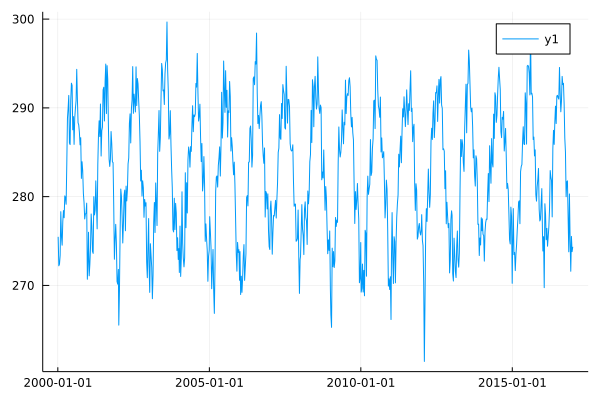

In [13]:
plot(europe.time.values,europe[Variable="air_temperature_2m", lat=50, lon=11].data)

## Make computations on every element of the cube
* Computations are only registered
* Computations are done with other computations together

In [14]:
celsiuscube = map(europe[Variable="air_temperature_2m"]) do x
	x - 273.15
end


YAXArray with the following dimensions
lon                 Axis with 172 Elements from -9.875 to 32.875
lat                 Axis with 140 Elements from 69.875 to 35.125
time                Axis with 782 Elements from 2000-01-05T00:00:00 to 2016-12-30T00:00:00
Total size: 143.67 MB


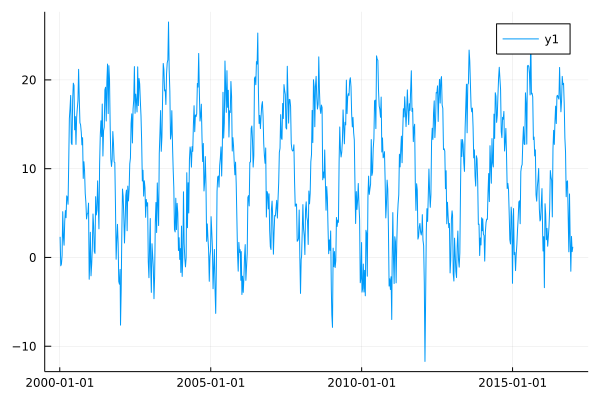

In [16]:
plot(europe.time.values, celsiuscube[lat=50, lon=11].data)

## Make computations along named Axes
* User defined functions
* Use the whole Julia Ecosystem

In [17]:
function prange(pix_prange, pix,threshold)
   	q5, q95 = quantile(pix, [threshold, 1-threshold])
   	pix_prange .=q95 - q5
end

prange (generic function with 1 method)

In [18]:
smalldata = subsetcube(celsiuscube, region="Greece") 
prange_greece = mapCube(prange, smalldata, .05,  indims = InDims("Time"), outdims = OutDims())

YAXArray with the following dimensions
lon                 Axis with 34 Elements from 19.875 to 28.125
lat                 Axis with 27 Elements from 41.625 to 35.125
Total size: 7.17 KB


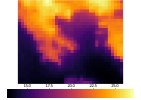

In [19]:
plotMAP(prange_greece)

## Make Moving Window Computations



In [20]:
function movingmean(xout, xin)
    xout .= mean(xin)
end

function movingmean(cube::YAXArray)
    indims = InDims(MovingWindow("lat", 1,1),MovingWindow("lon", 1,1))
    outdims=OutDims()
    mapCube(movingmean, cube; indims=indims, outdims=outdims)
end

movingmean (generic function with 2 methods)

In [21]:
movingavgprange = movingmean(prange_greece)

YAXArray with the following dimensions
lon                 Axis with 34 Elements from 19.875 to 28.125
lat                 Axis with 27 Elements from 41.625 to 35.125
Total size: 7.17 KB


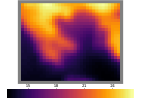

In [22]:
plotMAP(movingavgprange)

## Cube Axes are cubes as well

* Use Cube Axes in the inner functions 
* Combine multiple cubes
* Define the output dimension

In [23]:
using LombScargle

In [24]:
function clombscargle(xout, xin, times)
    ind = .!ismissing.(xin)
    ts = collect(nonmissingtype(eltype(xin)), xin[ind])
    x = times[ind]
    if length(ts) < 10
       @show length(ts)
       xout .= missing
       return
    end
    datediff = Date.(x) .- Date(x[1])
    dateint = getproperty.(datediff, :value)
    pl = LombScargle.plan(dateint, ts)
    pgram = LombScargle.lombscargle(pl)
    lsperiod= findmaxperiod(pgram)
    lspower = findmaxpower(pgram)
    lsnum = LombScargle.M(pgram)
    perval = isempty(lsperiod) ? missing : lsperiod[1]    
    xout .= [lsnum, perval, lspower]
end

clombscargle (generic function with 1 method)

In [25]:
function LombScargle.lombscargle(cube::YAXArray, kwargs...)
    indims = InDims("Time")
    lombax = CategoricalAxis("LombScargle", ["Number of Frequencies", "Period with maximal power", "Maximal Power"])
    #@show cube
    timeax = ESDL.getAxis("Time", cube)
    od = OutDims(lombax)
    mapCube(clombscargle, (cube, timeax), indims=(indims, indims), outdims=od)
end

In [26]:
lombgreece = lombscargle(celsiuscube[region="Greece"])

YAXArray with the following dimensions
LombScargle         Axis with 3 elements: Number of Frequencies Period with maximal power Maximal Power 
lon                 Axis with 34 Elements from 19.875 to 28.125
lat                 Axis with 27 Elements from 41.625 to 35.125
Total size: 21.52 KB


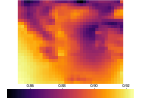

In [27]:
plotMAP(lombgreece[LombScargle="Maximal Power"])

## Easy parallelization on multiple cores and multiple nodes¶
* Use threads on a single computer 
* Use Distributed on multiple computers
* Works also with ClusterManagers like SLURM

In [28]:
using Distributed
addprocs(3)

3-element Vector{Int64}:
 2
 3
 4

In [29]:
@everywhere begin
    using Pkg
    Pkg.activate(".")
end

In [30]:
@everywhere begin
    using ESDL, Statistics
    function prange(pix_prange, pix,threshold)
        q5, q95 = quantile(pix, [threshold, 1-threshold])
        pix_prange .=q95 - q5
    end
end

In [34]:
@time prangecelsius = mapCube(prange, celsiuscube, .05,  indims = InDims("Time"), outdims = OutDims());

 33.525610 seconds (20.69 k allocations: 1.263 MiB, 0.06% compilation time)


## Load Reference polygons

In [36]:
countrycube = cubefromshape("data/ne_50m_admin_0_countries",europe, labelsym=:NAME)

YAXArray with the following dimensions
lon                 Axis with 172 Elements from -9.875 to 32.875
lat                 Axis with 140 Elements from 69.875 to 35.125
labels: Dict{Int32, String}(55 => "Spain", 32 => "United Kingdom", 219 => "Belarus", 185 => "Czechia", 104 => "Morocco", 62 => "Slovenia", 183 => "Faeroe Is.", 218 => "Belgium", 173 => "Estonia", 235 => "Andorra"…)
Total size: 94.06 KB


## Use table interface
* Use data as a dataframe
* Combine multiple cubes in one table

In [37]:
table = CubeTable(tair=celsiuscube, country=countrycube, include_axes=("lon","lat","time"));

## Fit Online Statistics

In [49]:
r = cubefittable(table, WeightedMean, :tair, weight=(i->abs(cosd.(i.lat))), by=(:country,r->month(r.time)))

YAXArray with the following dimensions
Label               Axis with 47 elements: Spain United Kingdom .. Malta Netherlands 
Category2           Axis with 12 elements: 1 2 .. 11 12 
Total size: 4.41 KB


In [50]:
renameaxis!(r, "Category2" => CategoricalAxis("Month", monthname.(1:12)))
renameaxis!(r, "Label"=> "Country")


YAXArray with the following dimensions
Country             Axis with 47 elements: Spain United Kingdom .. Malta Netherlands 
Month               Axis with 12 elements: January February .. November December 
Total size: 4.41 KB


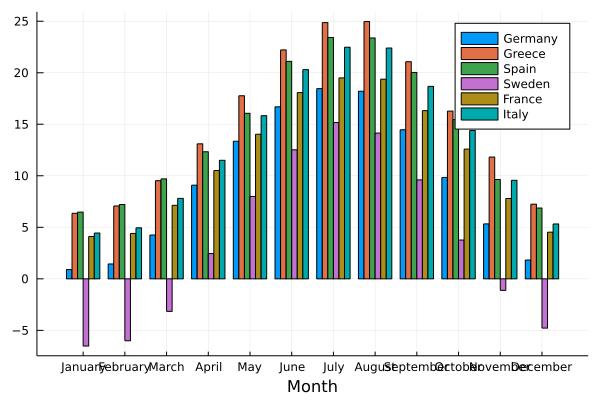

In [41]:
plotXY(r[Country=["Germany", "Greece", "Spain","Sweden", "France", "Italy"]], group="Country", xaxis="Month", label="")

## Use Python Packages
* Use PyCall to have access to the python ecosystem
* Use RCall for R packages

## Questions ?

## Auxillary functions

In [ ]:
#] add https://github.com/esa-esdl/ESDL.jl/ https://github.com/esa-esdl/ESDLPlots.jl

In [40]:
#]dev --local YAXArrays